# Running colab?

In [1]:
running_colab = False

In [2]:
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_parent_directory = 'drive/MyDrive/ColabData/'
    !pip install -r "drive/MyDrive/ColabData/requirements.txt"
else:
    colab_parent_directory = ''

# Setting up directories/files

In [3]:
data_directory = "data"
!mkdir -p $f'{colab_parent_directory}{data_directory}'

params_path = f'{colab_parent_directory}{data_directory}/agents_params.csv'
metrics_path = f'{colab_parent_directory}{data_directory}/agents_metrics.csv'

# Imports

In [4]:
import time
from tensorforce import Agent, Environment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
%load_ext tensorboard

# import pour visualiser les parties
from IPython.display import display, HTML
from IPython.display import clear_output

# Plotting utils

In [5]:
# fonction pour ranger en ordre croissant un dico dans le but de le plotter avec plt
def sort_dico(dico):
    dico_sorted={}
    for k,v in dict(sorted(dico.items())).items():
        k_str = str(k)
        dico_sorted[k_str] = v

    return dico_sorted

In [6]:
# fonction pour plotter la distribution des scores et des max tiles
# à utiliser avec la fonction de test 'test_agent' et ce qu'elle retourne
# dico_sorted = sort_dico(dico_max_tiles_distribution)
# rewards = liste_score

def plot_metrics(dico_sorted,rewards):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Max tile distribution')
    plt.bar(*zip(*dico_sorted.items()))

    plt.subplot(1, 2, 2)
    plt.title('Score distribution')
    sns.histplot(rewards, kde=True)

    print(f'Mean score over the test: {np.mean(rewards)}')
    print(f'Median score over the test: {np.median(rewards)}')
    print(f'Std score over the test: {np.std(rewards)}')
    print(f'Max tile over the test: {max([int(bins) for bins in dico_sorted.keys()])}')

In [7]:
# fonction pour imprimer les parties avec un visuel proche de celui du jeu 2048

def pretty_print(layout):
    from math import log2
    def parse_color(cell_value):
        if cell_value>0:
            colors = ["#EEE4DA", "#ECE0CA", "#F2B179", "#F59565", "#F57C5F", "#F65D3B", "#EDCE71", "#EDCC63", "#EDC850", "#EDC53F", "#EEC22E", "#3E3933"]
            return colors[int(log2(cell_value))-1]
        else:
            return "#CDC0B4"

    def cell_block(cell_value):
        return '''
        <td style=font-size:{}px;background-color:#BBADA0;text-align:center;width:100%>
            <div style=color:#776E65;background-color:{};width:60px;height:60px;margin:auto;display:flex;align-items:center;justify-content:center;border-radius:6px;font-family:serif;font-size:medium><strong>{}</strong>
            </div>
        </td>'''.format('1', parse_color(cell_value), cell_value if cell_value>0 else '')
    return '''
            <div style=background-color:#BBADA0;width:300px;height:300px>
            <table style=width:100%;height:100%>
              <tr>
                {}
                </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
              <tr>
              {}
              </tr>
            </table>
            </div>
            '''.format('\n'.join([cell_block(val) for val in layout[0,:]]),
                      '\n'.join([cell_block(val) for val in layout[1,:]]),
                       '\n'.join([cell_block(val) for val in layout[2,:]]),
                       '\n'.join([cell_block(val) for val in layout[3,:]]))


# Useful code snippets

Render "beautiful" 2048 grid:

`plt.imshow(environment._environment.environment.render(mode="rgb_array"))`

Illegal move reward:

`environment._environment.environment.set_illegal_move_reward(-10)`

Log2 reward:

`log2_reward = reward if reward <= 0 else np.log2(reward)`

Show TensorBoard graphs:

`%tensorboard --logdir summaries` (with parameter `summarizer=dict(directory='{data_directory}/...')` in the `Agent.create()` method)

# Training functions

In [8]:
def create_agent_and_env(env_params, agent_params):
    agent_name = agent_params["agent_name"]
    agent_params_ = dict(agent_params)
    del agent_params_["agent_name"] # A TensorForce agent doesn't take name as a parameter
    
    
    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
    )

    # create an agent
    agent = Agent.create(
        agent = 'dqn',
        environment = environment,
        **agent_params_#,
        #summarizer = dict(directory=f'{colab_parent_directory}{data_directory}/{agent_params["agent_name"]}/TensorBoard',
                          #summaries=["reward"])
        # Uncomment the above lines to store logs in TensorBoard (but training will take more time)
    )
    return (environment, agent)

In [9]:
def train_agent(environment, agent, num_episodes, print_freq, agent_name, training_round = 0):

    # instantiate lists to save metrics
    
    train_max_tiles = []
    train_scores = []
    train_moves_numbers = []
    episode_train_times = []
    
    test_max_tiles = []
    test_scores = []
    test_moves_numbers = []
    episode_test_times = []

    for episode in range(num_episodes):
        
        # Training
        state = environment.reset()
        terminal = False

        #Checking metrics while training
        num_moves = 0
        start_episode_train_time = time.time()

        while not terminal:
            
            # Agent acting (invalid moves are not allowed)
            action = agent.act(states=dict(state=state,  action_mask=environment._environment.environment.get_invalid_moves()))
            state, terminal, reward = environment.execute(actions=action)
            
            # Using the log2 of the reward seems to give better results
            log2_reward = reward if reward <= 0 else np.log2(reward)
            agent.observe(terminal=terminal, reward=log2_reward)

            # Number of moves
            num_moves += 1

        # Saving metrics
        train_max_tiles.append(environment._environment.environment.Matrix.max())
        train_scores.append(environment._environment.environment.score)
        train_moves_numbers.append(num_moves)
        episode_train_times.append(round(time.time() - start_episode_train_time,2))

        if episode % print_freq == 0:
            print('Episode {}: score = {}, terminal = {}, max_tile={}, moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, train_max_tiles[-1], num_moves, round(time.time() - start_episode_train_time,2)))
        
        # Testing
        num_moves = 0
        start_episode_test_time = time.time()
        
        states = environment.reset()
        internals = agent.initial_internals()
        terminal = False

        while not terminal:
            actions, internals = agent.act(
                states= {
                    "state":states,
                    "action_mask":environment._environment.environment.get_invalid_moves()},
                internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
        
        # Saving metrics
        test_max_tiles.append(environment._environment.environment.Matrix.max())
        test_scores.append(environment._environment.environment.score)
        test_moves_numbers.append(num_moves)
        episode_test_times.append(round(time.time() - start_episode_test_time,2))

        if episode % print_freq == 0:
            print('Test episode {}: score = {}, terminal = {}, max_tile={}, moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, test_max_tiles[-1], num_moves, round(time.time() - start_episode_test_time,2)))
        
    # Storing agent
    agent.save(f'{colab_parent_directory}{data_directory}/saved_agents/{agent_name}/agent_round_{training_round}', filename=agent_name)
    
    # Storing metrics
    episodes_index = range(len(train_scores))
    
    training_metrics_dict = {
        'agent_name': agent_name,
        'context': "training",
        'round': training_round,
        'episode_number': episodes_index,
        'max_tile': train_max_tiles,
        'score': train_scores,
        'moves_number': train_moves_numbers,
        'episode_play_time' : episode_train_times
    }
    
    test_during_train_metrics_dict = {
        'agent_name': agent_name,
        'context': "test_during_train",
        'round': training_round,
        'episode_number': episodes_index,
        'max_tile': test_max_tiles,
        'score': test_scores,
        'moves_number': test_moves_numbers,
        'episode_play_time' : episode_test_times
    }
    
    training_metrics_df = pd.DataFrame(training_metrics_dict)
    test_during_train_metrics_df = pd.DataFrame(test_during_train_metrics_dict)
    metrics_df = training_metrics_df.append(test_during_train_metrics_df)
    
    try: # In case the .csv does not exist yet.
        csv_metrics_df = pd.read_csv(metrics_path)
        metrics_df = csv_metrics_df.append(metrics_df)
    except FileNotFoundError:
        pass
    metrics_df.to_csv(metrics_path, index=False)
    
    return (metrics_df, agent)

In [10]:
def save_params(agent_params, env_params):    
    params_df = pd.DataFrame([{**agent_params, **env_params}]) # Merging dicts and creating a dataframe with 1 row
    try: # In case the .csv does not exist yet.
        csv_params_df = pd.read_csv(params_path)
        params_df = csv_params_df.append(params_df, ignore_index=True)
    except FileNotFoundError:
        pass
    params_df.to_csv(params_path, index=False)

# Example of loading an agent (useful for training or testing)

```python
# An env needs to be created first
environment_load = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
    )

# Then we load the agent
APG_20K = Agent.load(directory=f"{data_directory}/APG_20K/agent_round0", filename="APG_20K", environment=environment_load)
```

# Training

Variable parameter example:

```python
exploration = dict(
    type = 'exponential',
    unit ='episodes',
    num_steps = 10000,
    initial_value = 0.2,
    decay_rate = 0.0005
)
````

In [11]:
agent_params = {
    "agent_name": input("Agent name (only letter, digits and underscores). NO SPACE: "),
    'batch_size': 16,
    'update_frequency': 4,
    'learning_rate': 0.0001,
    'discount': 0.99,
    'memory': 10000,
    "exploration":{
        "type": "exponential",
        "unit": "episodes",
        "num_steps": 10000,
        "initial_value": 0.07,"decay_rate": 0.0001
    },
    'target_sync_frequency': 4
}

env_params = {
    'max_episode_timesteps': 100000
}

if (not agent_params["agent_name"]) or (" " in agent_params["agent_name"]):
    print ("NO SPACE")
    agent_params = 0

In [12]:
# Saving params to .csv in {data_directory} folder
save_params(agent_params, env_params)

In [13]:
# Creating agent and environnement
environment, agent = create_agent_and_env(env_params, agent_params)

In [ ]:
# Train ! Increment training round for several round of trainings

training_params = {
    "num_episodes": 5_000,
    "print_freq": 100,
    "agent_name": agent_params["agent_name"],
    "training_round": input("Training round? ")
}

metrics_df, agent = train_agent(environment, agent, **training_params)

# Plotting training data

In [20]:
# Reading metrics of trained agents:
df = pd.read_csv(metrics_path).set_index(['agent_name', 'context', 'round', 'episode_number'])
df

max_tile   score  \
agent_name      context           round episode_number                     
marco_test      training          0     0                    128  1936.0   
                                        1                     64  1420.0   
                                        2                    128  2000.0   
                                        3                    128  1192.0   
                                        4                    256  2428.0   
...                                                          ...     ...   
marco_colab_cpu test_during_train 0     4997                 128  1612.0   
                                        4998                 512  6476.0   
                                        4999                 128  1404.0   
test_agent      training          0     0                     64   600.0   
                test_during_train 0     0                    128  1372.0   

                                                        moves_number  \
agent_name      context           round episode_number                 
marco_test      training          0     0                        179   
                                        1                        160   
                                        2                        182   
                                        3                        124   
                                        4                        210   
...                                                              ...   
marco_colab_cpu test_during_train 0     4997                       0   
                                        4998                       0   
                                        4999                       0   
test_agent      training          0     0                         79   
                test_during_train 0     0                          0   

                                                        episode_play_time  
agent_name      context           round episode_number                     
marco_test      training          0     0                            6.27  
                                        1                            1.18  
                                        2                            1.48  
                                        3                            1.18  
                                        4                            1.56  
...                                                                   ...  
marco_colab_cpu test_during_train 0     4997                         0.41  
                                        4998                         1.13  
                                        4999                         0.35  
test_agent      training          0     0                            6.35  
                test_during_train 0     0                            0.82  

[30002 rows x 4 columns]

In [36]:
df.score["marco_test"]["training"][0]

episode_number
0       1936.0
1       1420.0
2       2000.0
3       1192.0
4       2428.0
         ...  
4995    8636.0
4996    2720.0
4997    8592.0
4998    5788.0
4999    7488.0
Name: score, Length: 5000, dtype: float64

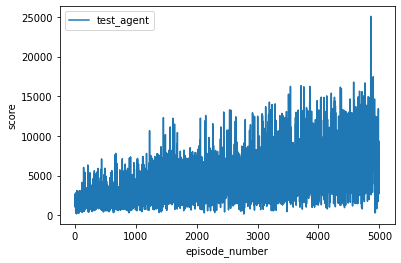

In [39]:
# Raw training data
sns.lineplot(data=df["score"][agent_params["agent_name"]]["training"][int(training_params["training_round"])], label = agent_params["agent_name"]);

Training time of test_agent: 743 minutes


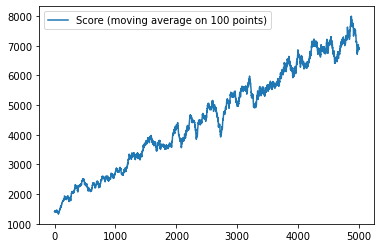

In [41]:
# Smoothed curves (moving average on N points)
N = 100
print(f"Training time of {agent_params['agent_name']}:", round(metrics_df["episode_play_time"].sum()/60), "minutes")
sns.lineplot(data = uniform_filter1d(df["score"][agent_params["agent_name"]]["training"][int(training_params["training_round"])], size=N, mode = "reflect"), label = f"Score (moving average on {N} points)");

In [42]:
_dir = f"{colab_parent_directory}{data_directory}/{agent_params['agent_name']}"
%tensorboard --logdir $_dir

# Testing

Fast testing

In [ ]:
def fast_test_agent(agent, episodes_n):
    start_testing_time = time.time()

    environment = Environment.create(
        environment = 'gym',
        level = '2048-v0', 
        max_episode_timesteps = 10_000
    )

    scores_list = []

    for episode in range(episodes_n):
        score = 0
        states = environment.reset()
        internals = agent.initial_internals()
        terminal = False

        while not terminal:
            actions, internals = agent.act(
                states= {
                    "state":states,
                    "action_mask":environment._environment.environment.get_invalid_moves()},
                internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            score += reward

        scores_list.append(score)

    testing_time = time.time() - start_testing_time
    print("Testing time: ", testing_time)
    
    return scores_list

Comprehensive testing (with visualization, and best/worst game save)

In [ ]:
# Evaluate for n episodes
def test_agent(agent,n_episode,visualization,pause=0.01):
    start_testing_time = time.time()
    #definir l'env
    environment = Environment.create(environment = 'gym', level = '2048-v0', 
    max_episode_timesteps = 10_000
    )

    #dictionnaire pour obtenir la distribution des max tiles de chaque episode
    dico_max_tiles_distribution = {}
    # liste des score par episode
    liste_score=[]
    # dictionnaire pour récupérer la meilleure et la pire partie du test
    dico_best_worst_episode = {'Worst':[],'Best':[], 'Episode # Worst':[], 'Episode # Best':[]}

    for episode in range(n_episode):
        sum_rewards = 0.0
        states = environment.reset()
        list_states=[]
        internals = agent.initial_internals()
        terminal = False
        if visualization == 'yes':
            clear_output(wait=True)
            print(f'Game #: {episode+1}')
            time.sleep(3)

        while not terminal:
            actions, internals = agent.act(
                states= {
                    "state":states,
                    "action_mask":environment._environment.environment.get_invalid_moves()},
                internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            matrix = environment._environment.environment.Matrix
            list_states.append(matrix.copy())
            sum_rewards += reward
            if visualization == 'yes':
                clear_output(wait=True)
                display(HTML(pretty_print(matrix)))
                time.sleep(pause)

        liste_score.append(sum_rewards)

        if sum_rewards >= max(liste_score):
            dico_best_worst_episode['Best'] = list_states
            dico_best_worst_episode['Episode # Best'] = episode
        elif sum_rewards <= min(liste_score):
            dico_best_worst_episode['Worst'] = list_states
            dico_best_worst_episode['Episode # Worst'] = episode

        dico_max_tiles_distribution.setdefault(environment._environment.environment.Matrix.max(),0)
        dico_max_tiles_distribution[environment._environment.environment.Matrix.max()] += 1
        if visualization == 'yes':
            if environment._environment.environment.Matrix.max() < 2048:
                print(f"My final score is {environment._environment.environment.score} with a max tile at {environment._environment.environment.Matrix.max()}. Let's try again!")
            else:
                print(f"My final score is {environment._environment.environment.score} with a max tile at {environment._environment.environment.Matrix.max()}. I mastered this game!")
            time.sleep(3)
    testing_time = time.time() - start_testing_time
    print("Testing time: ", testing_time)
    return dico_best_worst_episode, liste_score, dico_max_tiles_distribution


In [ ]:
results = test_agent(agent, 30, 'no')

In [ ]:
restults2 = fast_test_agent(agent, 30)

In [ ]:
plot_metrics(sort_dico(results[2]), results[1])